In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from IPython.display import HTML, display
from tqdm import tqdm
import pytz
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
from sklearn.utils import shuffle
from random import randrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tw = pytz.timezone('Asia/Taipei')

Mounted at /content/drive


In [2]:
#@title Defined Function

def PlotImg(x_train, y_train):
  plt.figure(1,figsize = (20,50))
  img = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2])
  labels = []
  for i in range(0,10):
    if y_train.shape[0] == 0:
      plt.subplot(1,10,i+1)
      plt.imshow(img[randrange(x_train.shape[0])],cmap='Greys',interpolation='nearest')
      plt.axis('off')
    else:
      plt.subplot(1,10,i+1)
      index = randrange(x_train.shape[0])
      plt.imshow(img[index],interpolation='nearest')
      plt.axis('off')
      labels.append(y_train[index])
  return labels

def PlotHist(history,tag):
  fig = plt.figure(1,figsize = (12,5))
  plt.subplot(1,2,1)
  plt.title('Model Loss')
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper right')
  plt.subplot(1,2,2)
  plt.title('Model Accuracy')
  plt.plot(history.history['accuracy'], label='Train accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'lower right')
  fig.savefig('/content/drive/My Drive/fer2013/saveData/CNN_model_acc_%s.jpg'%tag)
def printImg(m):
  plt.imshow(m)
  plt.axis('off')

In [3]:
#@title Data2
class fer2013:
  def __init__(self):
    
    data = pd.read_pickle('/content/drive/My Drive/fer2013/fer2013.pkl')
    classNum = max(data['emotion'])+1
    self.emotionNum = np.asarray(data['emotion']).astype('int')
    self.emotion = keras.utils.to_categorical(data['emotion'], classNum)
    self.pixels = np.stack(data['pixels'], axis = -3)
    self.usage = data['Usage'].tolist()
    self.classNum = classNum
    self.total = self.pixels.shape[0]

    
  def aug(self):
    vImg = np.copy(self.pixels)
    #with tqdm(total=self.total) as pbar:
    for i in range (self.total):
      #pbar.update(1) 
      vImg[i] = np.flip(self.pixels[i],1)
    
    self.pixels = np.vstack((self.pixels,vImg)).reshape(self.total*2,
                                                          self.pixels.shape[1],
                                                          self.pixels.shape[2],1)
    self.emotionNum = np.hstack((self.emotionNum,self.emotionNum))
    self.emotion = keras.utils.to_categorical(self.emotionNum,self.classNum)
    self.total = self.pixels.shape[0]
  
  def shuffle(self, seed = 0):
    #print('total num = ',df.total)
    #indices = np.linspace(0,df.total-1,df.total).astype(int)
    #rnd = np.random.RandomState(seed)
    #rnd.shuffle(indices)

    #self.pixels=self.pixels[indices,:,:,:]
    #self.emotionNum=self.emotionNum[indices]
    #self.emotion = self.emotion[indices,:]

    indices = np.linspace(0,len(self.pixels)-1,len(self.pixels)).astype(int)
    randomState = np.random.RandomState(seed=seed)
    randomState.shuffle(indices)
    self.emotionNum[indices] = self.emotionNum
    self.pixels[indices] = self.pixels
    #self.Usage[indices] = self.Usage
    self.emotion[indices] = self.emotion
  
  def label(self,x):
    if x == 0:
      return 'Angry'
    elif x == 1:
      return 'Disgust'
    elif x == 2:
      return 'Fear'
    elif x == 3:
      return 'Happy'
    elif x == 4:
      return 'Sad'
    elif x == 5:
      return 'Surprise'
    elif x == 6:
      return 'Neutral'
  def split(self,test_size=0.2, seed = None):
    x_train, x_test, y_train, y_test = train_test_split(self.pixels,self.emotion, test_size=0.2, random_state=int(seed))
    return x_train, x_test, y_train, y_test
  
df = fer2013()

# print('total pixels shape',df.pixels.shape)
# print('total targets shape',df.emotion.shape)
# print('first unit cell value',df.pixels[0][0][0])
# print('first emotion',df.emotionNum[0])
# print('first targets',df.emotion[0],'\n\n')

df.aug()

# print('After augment')
# print('total pixels shape',df.pixels.shape)
# print('total targets shape',df.emotion.shape)
# print('first unit cell value',df.pixels[0][0][0])
# print('first emotion',df.emotionNum[0])
# print('first targets',df.emotion[0],'\n\n')

df.shuffle(seed=11)
df.shuffle(seed=0)
df.shuffle(seed=5)

# print('After shuffle')
# print('total pixels shape',df.pixels.shape)
# print('total targets shape',df.emotion.shape)
# print('first unit cell value',df.pixels[0][0][0])
# print('first emotion',df.emotionNum[0])
#  print('first targets',df.emotion[0],'\n\n')

trainX,testX, trainY,testY = df.split(seed=11)
train_norm, test_norm = trainX, testX

# print('After normalize')
# print('total pixels shape',train_norm.shape)
# print('total targets shape',trainY.shape)
# print('first unit cell value',train_norm[0][0][0])
# print('first targets',trainY[0],'\n\n')
# printImg(train_norm[0].reshape(48,48))


In [ ]:
#@title ~80% in Matthew
def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#@title loss: 0.7623 - accuracy: 0.7166 - val_loss: 0.7878 - val_accuracy: 0.7429
def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

print('Data Size/num. parameters: %0.3f'%(len(train_norm)/model.count_params()))
#model.summary()

In [ ]:
#@title loss: 0.5924 - accuracy: 0.7923 - val_loss: 0.6664 - val_accuracy: 0.7936

def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

print('Data Size/num. parameters: %0.3f'%(len(train_norm)/model.count_params()))
#model.summary()

In [ ]:
#@title loss: 0.2535 - accuracy: 0.9163 - val_loss: 0.5626 - val_accuracy: 0.8617

def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])
#model.summary()

In [ ]:
#@title loss: 0.3635 - accuracy: 0.8748 - val_loss: 0.5161 - val_accuracy: 0.8592

def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

In [ ]:
#@title loss: 0.2055 - accuracy: 0.9333 - val_loss: 0.3215 - val_accuracy: 0.9174
# Triple shuffle
def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

In [ ]:
#@title loss: loss: 0.0608 - accuracy: 0.9820 - val_loss: 0.3822 - val_accuracy: 0.9217
def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

In [ ]:
#@title loss: 0.1258 - accuracy: 0.9627 - val_loss: 0.3108 - val_accuracy: 0.9267
def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

In [5]:
#@title loss: 0.0892 - accuracy: 0.9710 - val_loss: 0.2710 - val_accuracy: 0.9278
def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    #model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

In [4]:
#@title loss: 0.0892 - accuracy: 0.9710 - val_loss: 0.2710 - val_accuracy: 0.9278
def define_model(input_shape=(28,28,1),output_shape=10):
    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    #model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model.summary()
model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])

NameError: ignored

In [ ]:
# model = define_model(input_shape=trainX[0].shape,output_shape=trainY.shape[1])
# print('Data Size/num. parameters: %0.3f'%(len(train_norm)/model.count_params()))

tag = datetime.now(tz=tw).strftime("%m_%d_%Y_%H_%M")
print('Input image size: ',trainX[0].shape)
print('Data Size/num. parameters: %0.3f'%(len(train_norm)/model.count_params()))
# %%
es = EarlyStopping(monitor='val_loss',patience=15, mode='auto', verbose=1)
history = model.fit(train_norm, trainY, epochs=120, batch_size=32, validation_split=0.2, verbose=1,callbacks=[es],shuffle=True)
model.save('/content/drive/My Drive/fer2013/saveData/CNN_model_%s.h5'%tag)
plot_model(model, to_file='/content/drive/My Drive/fer2013/saveData/CNN_model_%s.png'%tag, show_shapes=True, show_layer_names=True)
PlotHist(history,tag)

Input image size:  (48, 48, 1)
Data Size/num. parameters: 0.002
Epoch 1/120
1436/1436 [==============================] - ETA: 0s - loss: 1.8398 - accuracy: 0.2562

In [ ]:
from sklearn import metrics
import scipy
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

pwd = '/content/drive/My Drive/fer2013/saveData/CNN_model_11_08_2020_16_57.h5'
model = tf.keras.models.load_model(pwd)

print(testX.shape)
print(testY.shape)

prediction = model.predict({'input': testX})
y_pred = np.argmax(prediction, axis=1).tolist()
y_act = np.argmax(testY, axis=1).tolist()

lb = [0,1,2,3,4,5,6]
lbb = [df.label(i) for i in lb]
print(lbb)

(14355, 48, 48, 1)
(14355, 7)
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(1,figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels',fontsize=)
    plt.xlabel('Predicted labels')
    plt.tight_layout()

Normalized confusion matrix


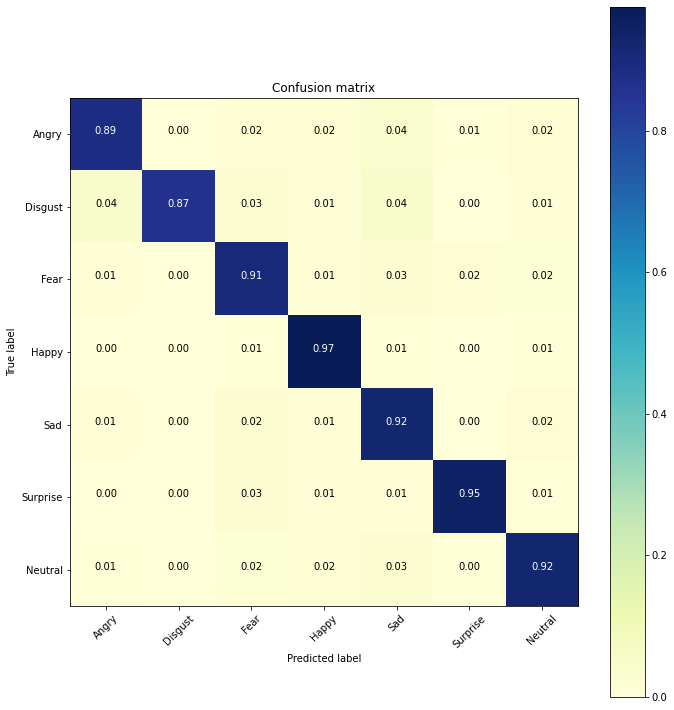